# Pneumonia detection from chest X-rays: model

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
from random import sample

import sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


## Early processing of metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('./data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
65116,00016075_002.png,No Finding,2,16075,61,M,AP,2500,2048,0.168000,0.168000,NaN,./data\images_008\images\00016075_002.png
17752,00004803_000.png,No Finding,0,4803,62,F,PA,2021,2021,0.194311,0.194311,NaN,./data\images_003\images\00004803_000.png
60009,00014814_000.png,No Finding,0,14814,51,M,PA,2992,2991,0.143000,0.143000,NaN,./data\images_007\images\00014814_000.png


We need to create  extra columns in your table with binary indicators of certain diseases rather than working directly with the 'Finding Labels' column

In [3]:
# Make a list of diseases
list_disease = np.unique(all_xray_df['Finding Labels'])
list_disease

# When multiple diseases are present we need to parse the strings
temp_list = [string.split('|') for string in list_disease]
# flatten the nested list
disease = np.unique([item for sublist in temp_list for item in sublist])
disease

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

In [4]:
#create new columns for each disease
for pathology in disease :
    all_xray_df[pathology] = all_xray_df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
all_xray_df['Multi_Finding'] = all_xray_df['Finding Labels'].apply(lambda x: 1 if x.find('|') > -1 else 0)

all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Multi_Finding
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,0


In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df.Pneumonia.astype(str)

In [6]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Multi_Finding,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,1,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,1,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,1,0,0,0,0,0,0,0,0,0


## Create your training and testing data:

In [7]:
def create_splits(df, y = 'Pneumonia', ratio = 0.8):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, val_data = model_selection.train_test_split(df, train_size = ratio, stratify = df[y], random_state = 14)
    
    # Undersample to have 50% of positive labels in the train set only
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    train_data_ratio = len(train_data[train_data.Pneumonia==1])/len(train_data)
    print('Percentage of Pneumonia images in training set: {perct:.2f}%'.format(perct= 100.0*train_data_ratio))
        
    # Undersample val_df to have 20% of Pneumonia patients
    p_idx = val_data[val_data.Pneumonia==1].index.tolist()
    nop_idx = val_data[val_data.Pneumonia==0].index.tolist()
    nop_sample = sample(nop_idx, 4*len(p_idx))
    val_data = val_data.loc[p_idx + nop_sample]
    val_data_ratio = len(val_data[val_data.Pneumonia==1])/len(val_data)
    print('Percentage of Pneumonia images in validation set: {perct:.2f}%'.format(perct = 100.0*val_data_ratio))
        
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(horizontal_flip = True, height_shift_range= 0.1, width_shift_range=0.1, rotation_range=20, 
                          shear_range = 0.1, zoom_range=0.1):
    
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = horizontal_flip, 
                              vertical_flip = False, 
                              height_shift_range= height_shift_range, 
                              width_shift_range=width_shift_range, 
                              rotation_range=rotation_range, 
                              shear_range = shear_range,
                              zoom_range=zoom_range)    
    return my_idg


def make_train_gen(my_train_idg, batch_size, dataframe, x= 'path',  y = 'pneumonia_class', image_size = (224, 224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    train_gen = my_train_idg.flow_from_dataframe(dataframe=dataframe, 
                                                 directory=None, 
                                                 x_col = x,
                                                 y_col = y,
                                                 class_mode = 'binary',
                                                 target_size = image_size, 
                                                 batch_size = batch_size
                                                )
    return train_gen


# Image augmentation is NOT suitable for validation set
def make_val_gen(my_val_idg, batch_size, dataframe,  x= 'path', y = 'pneumonia_class', image_size = (224, 224)):

    val_gen = my_val_idg.flow_from_dataframe(dataframe=dataframe, 
                                                 directory=None, 
                                                 x_col = x,
                                                 y_col = y,
                                                 class_mode = 'binary',
                                                 target_size = image_size, 
                                                 batch_size = batch_size
                                                )       
    return val_gen

In [9]:
train_df, val_df = create_splits(all_xray_df)

Percentage of Pneumonia images in training set: 50.00%
Percentage of Pneumonia images in validation set: 20.00%


In [10]:
#Check
train_gen = my_image_augmentation().flow_from_dataframe(dataframe=train_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224, 224), 
                                                 batch_size = 5)

Found 2290 validated image filenames belonging to 2 classes.


In [11]:
batch_size = 32
my_idg = my_image_augmentation()
train_gen = make_train_gen(my_idg, batch_size, train_df)
val_idg = ImageDataGenerator(rescale=1. / 255.0)
val_gen = make_val_gen(val_idg, 1024, val_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [12]:
## Pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

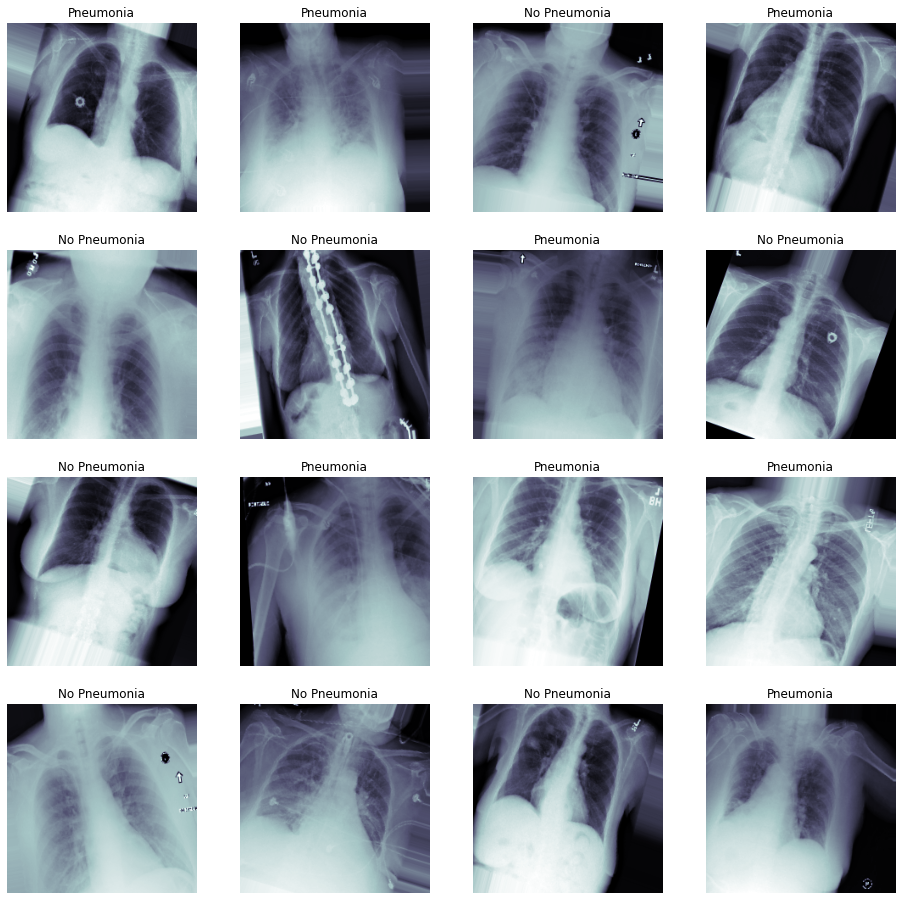

In [13]:
## Look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [14]:
# Load VGG16 model
model = VGG16(include_top=True, weights='imagenet')
for layer in model.layers[0:17]:
    layer.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')

    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False    
    return vgg_model


In [16]:
def build_my_model(vgg_model = load_pretrained_model(), optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy']):
    

    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(128, activation='relu'))
   
   
    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
        
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    return my_model

In [17]:
# Add checkpoints to your model,


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=20)

#lrs = LearningRateScheduler(decay_short)

callbacks_list = [checkpoint, early]#, lrs]

### Start training! 

In [18]:
tf.keras.backend.clear_session()

In [19]:
# train model
my_model = build_my_model()

In [20]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0

In [21]:
for layer in my_model.layers:
    print(layer.name, layer.trainable)

model True
flatten True
dropout True
dense True
dropout_1 True
dense_1 True
dropout_2 True
dense_2 True
dropout_3 True
dense_3 True
dense_4 True


In [22]:
history = my_model.fit(train_gen, 
                       validation_data = (valX, valY), 
                                  epochs = 50,
                                callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 0.7979 - binary_accuracy: 0.4952
Epoch 00001: val_loss improved from inf to 0.71470, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 42s 580ms/step - loss: 0.7979 - binary_accuracy: 0.4952 - val_loss: 0.7147 - val_binary_accuracy: 0.2549
Epoch 2/50
72/72 [==============================] - ETA: 0s - loss: 0.7331 - binary_accuracy: 0.4943
Epoch 00002: val_loss improved from 0.71470 to 0.69139, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 38s 531ms/step - loss: 0.7331 - binary_accuracy: 0.4943 - val_loss: 0.6914 - val_binary_accuracy: 0.5811
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.7062 - binary_accuracy: 0.5358
Epoch 00003: val_loss did not improve from 0.69139
72/72 [==============================] - 38s 533ms/step - loss: 0.7062 - binary_accuracy: 0.5358 - val_loss: 0.6927 - val_binary_accuracy: 0.5078
Epoch 4/

Epoch 27/50
72/72 [==============================] - ETA: 0s - loss: 0.6333 - binary_accuracy: 0.6511
Epoch 00027: val_loss did not improve from 0.55015
72/72 [==============================] - 41s 570ms/step - loss: 0.6333 - binary_accuracy: 0.6511 - val_loss: 0.6908 - val_binary_accuracy: 0.5703
Epoch 28/50
72/72 [==============================] - ETA: 0s - loss: 0.6401 - binary_accuracy: 0.6328
Epoch 00028: val_loss did not improve from 0.55015
72/72 [==============================] - 38s 524ms/step - loss: 0.6401 - binary_accuracy: 0.6328 - val_loss: 0.6141 - val_binary_accuracy: 0.6533
Epoch 29/50
72/72 [==============================] - ETA: 0s - loss: 0.6332 - binary_accuracy: 0.6467
Epoch 00029: val_loss did not improve from 0.55015
72/72 [==============================] - 39s 541ms/step - loss: 0.6332 - binary_accuracy: 0.6467 - val_loss: 0.6814 - val_binary_accuracy: 0.6025
Epoch 30/50
72/72 [==============================] - ETA: 0s - loss: 0.6320 - binary_accuracy: 0.6454
E

In [30]:
# Define a function that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_loss_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
def plot_accuracy_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training and Validation Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

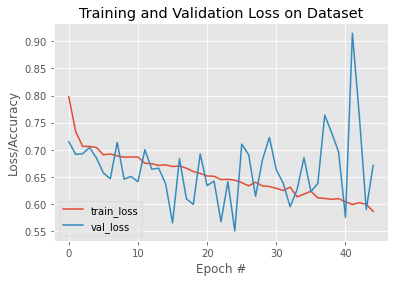

In [24]:
plot_loss_history(history)

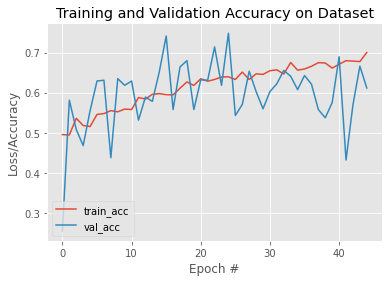

In [25]:
plot_accuracy_history(history)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [26]:
# After training, make  predictions to assess your model's overall performance
# Note that detecting pneumonia is hard even for trained expert radiologists, 
# so there is no need to make the model perfect.
my_model.load_weights(weight_path)
val_gen = make_val_gen(val_idg, len(val_df), val_df)
valX, valY = val_gen.next()
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

Found 1430 validated image filenames belonging to 2 classes.
45/45 [==============================] - 4s 81ms/step


In [27]:
def plot_roc_curve(t_y, p_y):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(t_y, p_y, pos_label=1.)
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    return

def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()    
    pass

def plot_conf_matrix(t_y, p_y, threshold = 0.5):
    conf_matrix = metrics.confusion_matrix(t_y, make_prediction_label(p_y, threshold = threshold))
    sns.heatmap(conf_matrix, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    return plt.show()

def make_prediction_label(p_y, threshold = 0.5):
    pred_label = [1 if score >= threshold else 0 for score in p_y]
    return pred_label

def evaluate_model(t_y, p_y, threshold):
    pred_label = make_prediction_label(p_y, threshold = threshold)

    accuracy = np.round(metrics.accuracy_score(t_y, pred_label), 3)
    precision = np.round(metrics.precision_score(t_y, pred_label, pos_label=1), 3)
    recall = np.round(metrics.recall_score(t_y, pred_label, pos_label=1), 3)
    F1 = np.round(metrics.f1_score(t_y, pred_label, pos_label=1), 3)
    AUC = np.round(metrics.roc_auc_score(t_y, pred_Y), 4)
    conf_matrix = metrics.confusion_matrix(t_y, pred_label)
    return threshold, accuracy, precision, recall, F1, AUC, conf_matrix

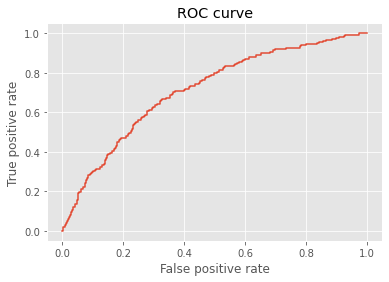

In [28]:
## plot ROC curve
plot_roc_curve(valY, pred_Y)

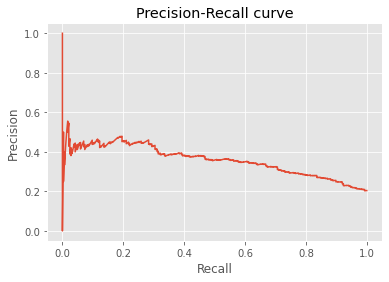

In [29]:
## plot Precision-recall curve
plot_precision_recall_curve(valY, pred_Y)

## Deciding on the proper classification threshold 
The threshold should optimize the model's performance for a given metric (e.g. accuracy, F1, precision, etc. )

Accuracy would not be a very good metric here because the dataset is imbalanced. 

In [31]:
col_names = ['Threshold', 'Accuracy', 'Precision', 'Recall',  'F1', 'AUC', 'Confusion matrix']
model_performance = pd.DataFrame(columns = col_names)

for thres in range(0,10):
    temp = {col_names[i]: list(evaluate_model(valY, pred_Y, thres/10))[i] for i in range(7)} 
    model_performance = model_performance.append(temp, ignore_index=True )
    
model_performance

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-pack

,Threshold,Accuracy,Precision,Recall,F1,AUC,Confusion matrix
0,0.0,0.200,0.200,1.000,0.333,0.7117,"[[0, 1144], [0, 286]]"
1,0.1,0.203,0.201,1.000,0.334,0.7117,"[[5, 1139], [0, 286]]"
2,0.2,0.256,0.210,0.986,0.346,0.7117,"[[84, 1060], [4, 282]]"
3,0.3,0.425,0.248,0.920,0.390,0.7117,"[[345, 799], [23, 263]]"
4,0.4,0.614,0.304,0.720,0.427,0.7117,"[[672, 472], [80, 206]]"
5,0.5,0.743,0.377,0.437,0.405,0.7117,"[[937, 207], [161, 125]]"
6,0.6,0.791,0.429,0.136,0.207,0.7117,"[[1092, 52], [247, 39]]"
7,0.7,0.801,0.545,0.021,0.040,0.7117,"[[1139, 5], [280, 6]]"
8,0.8,0.800,0.000,0.000,0.000,0.7117,"[[1144, 0], [286, 0]]"
9,0.9,0.800,0.000,0.000,0.000,0.7117,"[[1144, 0], [286, 0]]"


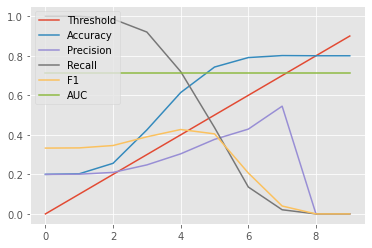

In [32]:
model_performance.plot()

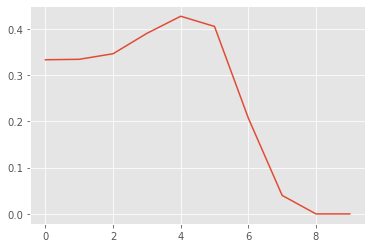

In [33]:
model_performance.F1.plot()

Based on the plot above, the recall falls below 0.9 at a threshold between 0.3 and 0.4, and accuracy is maximized at a threshold around 0.7. The threshold we pick depends on what we want to use the model for. Here, we intent to use it as a **screening test**: we need to identify **all the images that have pneumonia**. It is more important to avoid missing a single positive patient rather than avoid flagging patients with pneumonia when they don't actually have it (because a radiologist will see the images afterwards and give the final diagnostic). In this case, we want to minimize the false negative results, even if that means more false positive results.

For this reason, we want a recall of 0.8. This seems to happen between thresholds of 0.3 and 0.4. Let's look more closely:

In [34]:
model_performance = pd.DataFrame(columns = col_names)

for thres in range(0,20):
    temp = {col_names[i]: list(evaluate_model(valY, pred_Y, 0.3+ thres/100))[i] for i in range(7)} 
    model_performance = model_performance.append(temp, ignore_index=True )
    
model_performance

,Threshold,Accuracy,Precision,Recall,F1,AUC,Confusion matrix
0,0.30,0.425,0.248,0.920,0.390,0.7117,"[[345, 799], [23, 263]]"
1,0.31,0.441,0.250,0.899,0.391,0.7117,"[[373, 771], [29, 257]]"
2,0.32,0.463,0.257,0.888,0.398,0.7117,"[[408, 736], [32, 254]]"
3,0.33,0.488,0.264,0.871,0.405,0.7117,"[[449, 695], [37, 249]]"
4,0.34,0.506,0.268,0.850,0.408,0.7117,"[[481, 663], [43, 243]]"
5,0.35,0.532,0.278,0.836,0.417,0.7117,"[[522, 622], [47, 239]]"
6,0.36,0.550,0.283,0.815,0.420,0.7117,"[[554, 590], [53, 233]]"
7,0.37,0.563,0.286,0.790,0.420,0.7117,"[[579, 565], [60, 226]]"
8,0.38,0.580,0.291,0.766,0.422,0.7117,"[[611, 533], [67, 219]]"
9,0.39,0.594,0.295,0.745,0.423,0.7117,"[[636, 508], [73, 213]]"


It seems like a threshold of 0.36 is optimal to have a high recall. We have a lot of false positives, but few false negatives. The accuracy is only 0.550, F1 score is 0.420 and precision is 0.283. AUC is 0.71 


In [35]:
threshold = 0.36

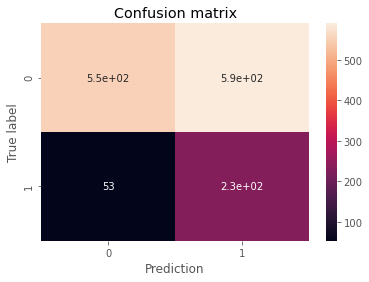

In [36]:
# Plot conf matrix
plot_conf_matrix(valY.astype(int), pred_Y, threshold)

There are more false positives (~590) than true negatives (~550).

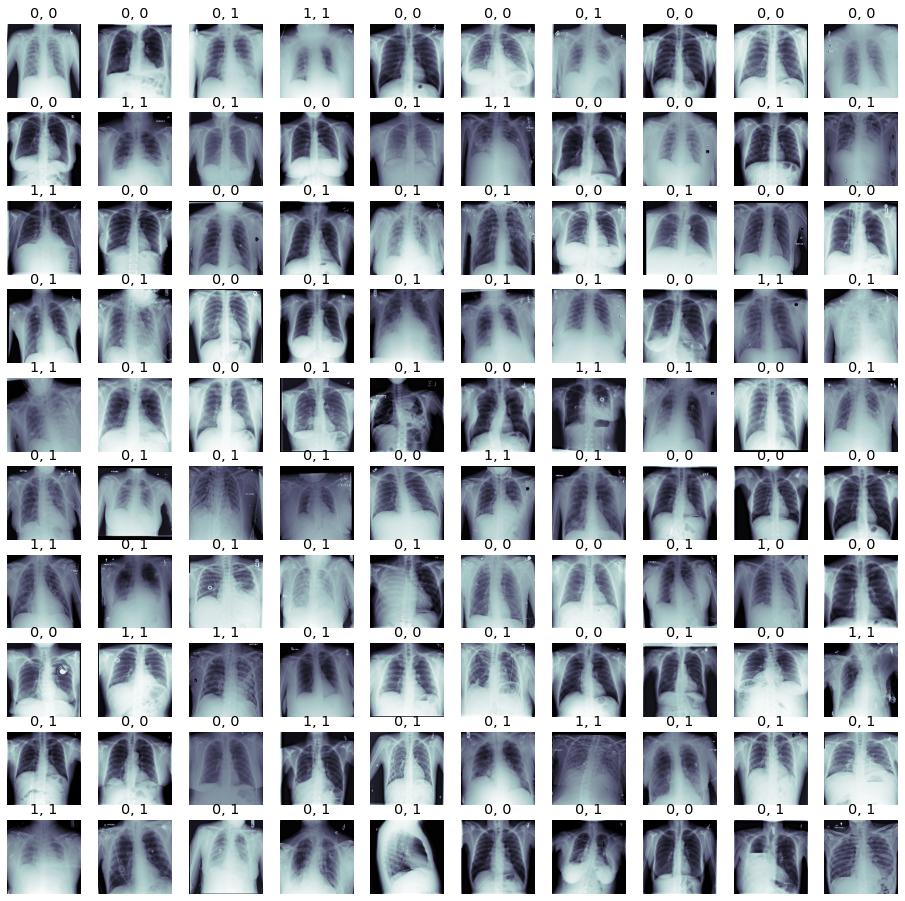

In [37]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [38]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

## Define the population used to train the model for the FDA Submission

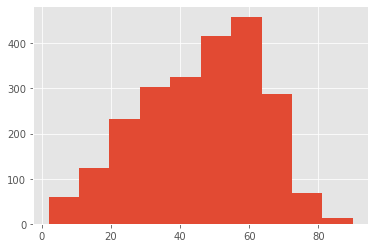

In [39]:
plt.hist(train_df['Patient Age'][train_df['Patient Age'] < 100]) # remove obvious typos (ages > 100)
plt.show()

In [40]:
train_df['Patient Age'].min()

2

In [41]:
train_df['Patient Age'][train_df['Patient Age'] < 100].max()

90

(array([1305.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         985.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

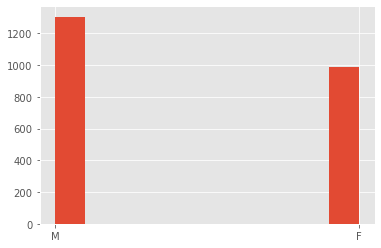

In [42]:
plt.hist(train_df['Patient Gender'])

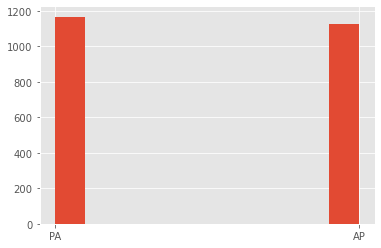

In [43]:
plt.hist(train_df['View Position'])
plt.show()